# Using the NYC Open Data API for GIS

This notebook explains how to query data from the NYC Open Data API, and integrate it into a GIS workflow. We'll use a simple example, pulling some data from [311 complaint records](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/about_data) to make a map of rat sightings in New York City. 

By the end of this tutorial, you should be able to:
1) Configure and manage a Python environment within ArcGIS Pro.
2) Interpret data, query, and API syntax from NYC Open Data.
3) Import and map data from the NYC Open Data API.

## Getting started
This was designed to be run as a Jupyter Notebook inside of ArcGIS Pro. To replicate, you can download this notebook, save it to the home folder associated with your `.aprx` project file, and then add the notebook to your project. 

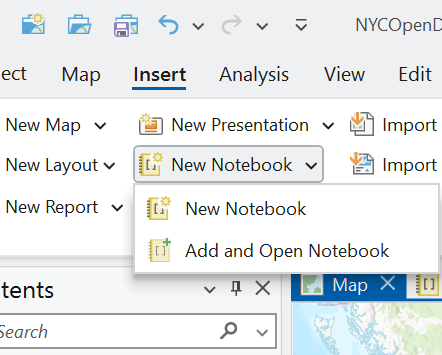

It will now be visible in a newly visible folder called `Notebooks` in the catalog pane. 

In [2]:
# Now load the relevant libraries
import arcpy
import os
import pandas
import sodapy
from sodapy import Socrata

Note that you may need to install the `sodapy` library, and it is not available in the default ArcGIS Python library directory. To do that, open your Python command terminal, and ensure you are working in the right environment. From there, install using the `pip` tool. 

```bash
pip install sodapy
```

Note that if you are running Python in ArcGIS for the first time, you will also need to clone your Python environment and activate the clone. The default Python environment in ArcGIS does not allow installation of new libraries. For details, here's some [ArcGIS documentation](https://pro.arcgis.com/en/pro-app/3.3/arcpy/get-started/clone-an-environment.htm).

In [3]:
# and set up your local working environment
aprx = arcpy.mp.ArcGISProject("Current") # your current aprx file
default_gdb = aprx.defaultGeodatabase  # the default geodatabase of the aprx
default_folder = aprx.homeFolder  # the default folder of the aprx
arcpy.env.overwriteOutput = True  # allows ArcGIS to overwrite files
map = aprx.listMaps()[0] # specify which map you're using 
crs = map.spatialReference  # borrow the default projection from that map

print("Directory: " + default_folder)
print("Geodatabase: " + default_gdb)
print("Activated map: " + map.name)
print("Coordinate reference system: " + crs.name)

Directory: C:\Users\johnl\My Drive (jlauerma@pratt.edu)\Teaching\INFO 612 Advanced GIS\Tutorials\NYCOpenData_API
Geodatabase: C:\Users\johnl\My Drive (jlauerma@pratt.edu)\Teaching\INFO 612 Advanced GIS\Tutorials\NYCOpenData_API\NYCOpenData_API.gdb
Activated map: Map
Coordinate reference system: WGS_1984_UTM_Zone_18N


## Understanding the NYC Open Data API

Like many large municipalities in the US, [NYC Open Data](https://opendata.cityofnewyork.us/) manages its public-facing databases with a content management system called [Socrata](https://dev.socrata.com/). The Socrata platform allows one to query data both through download tools and through an API. 

To access the API, navigate to the dataset you want and configure a query for the subset of data you want. Then instead of downloading a file choose the option for API endpoint.
<div>
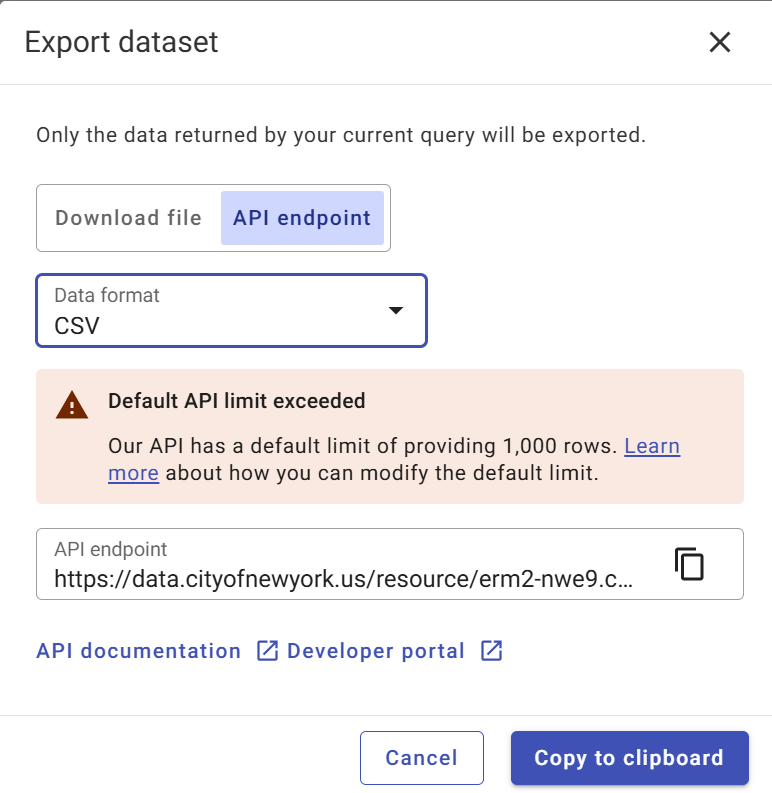
</div>

Copy the URL, and then note how the query is written into the structure of the URL. After the main URL, the first part of the query defines the dataset and file format: 
`erm2-nwe9`. After that the query you created will follow. In my case, I selected complaints about rodents in the 2025 calendar year. 

In [4]:
# now load this basic data 
url = "https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%0A%20%20%60unique_key%60%2C%0A%20%20%60created_date%60%2C%0A%20%20%60closed_date%60%2C%0A%20%20%60agency%60%2C%0A%20%20%60agency_name%60%2C%0A%20%20%60complaint_type%60%2C%0A%20%20%60descriptor%60%2C%0A%20%20%60location_type%60%2C%0A%20%20%60incident_zip%60%2C%0A%20%20%60incident_address%60%2C%0A%20%20%60street_name%60%2C%0A%20%20%60cross_street_1%60%2C%0A%20%20%60cross_street_2%60%2C%0A%20%20%60intersection_street_1%60%2C%0A%20%20%60intersection_street_2%60%2C%0A%20%20%60address_type%60%2C%0A%20%20%60city%60%2C%0A%20%20%60landmark%60%2C%0A%20%20%60facility_type%60%2C%0A%20%20%60status%60%2C%0A%20%20%60due_date%60%2C%0A%20%20%60resolution_description%60%2C%0A%20%20%60resolution_action_updated_date%60%2C%0A%20%20%60community_board%60%2C%0A%20%20%60bbl%60%2C%0A%20%20%60borough%60%2C%0A%20%20%60x_coordinate_state_plane%60%2C%0A%20%20%60y_coordinate_state_plane%60%2C%0A%20%20%60open_data_channel_type%60%2C%0A%20%20%60park_facility_name%60%2C%0A%20%20%60park_borough%60%2C%0A%20%20%60vehicle_type%60%2C%0A%20%20%60taxi_company_borough%60%2C%0A%20%20%60taxi_pick_up_location%60%2C%0A%20%20%60bridge_highway_name%60%2C%0A%20%20%60bridge_highway_direction%60%2C%0A%20%20%60road_ramp%60%2C%0A%20%20%60bridge_highway_segment%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60%2C%0A%20%20%60location%60%0AWHERE%0A%20%20%60created_date%60%0A%20%20%20%20BETWEEN%20%222025-01-01T11%3A12%3A18%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20AND%20%222025-08-04T11%3A12%3A18%22%20%3A%3A%20floating_timestamp%0A%20%20AND%20caseless_eq(%60complaint_type%60%2C%20%22Rodent%22)%0AORDER%20BY%20%60created_date%60%20DESC%20NULL%20FIRST"
test = pandas.read_csv(url)
test

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,65741430,2025-08-03T01:44:37.000,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11213,510 CROWN STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.665782,-73.941670,"\n, \n(40.665781714998694, -73.94167032782181)"
1,65742685,2025-08-03T01:23:15.000,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,3+ Family Apt. Building,11385,1754 DEKALB AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.707102,-73.916368,"\n, \n(40.70710237273882, -73.91636827488799)"
2,65741435,2025-08-03T01:21:05.000,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Vacant Lot,10452,951 WOODYCREST AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.831387,-73.928972,"\n, \n(40.831387191331984, -73.92897158905042)"
3,65744009,2025-08-03T01:17:53.000,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10452,963 WOODYCREST AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.831670,-73.928754,"\n, \n(40.831669762919574, -73.9287544719845)"
4,65744010,2025-08-03T01:15:34.000,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10452,957 WOODYCREST AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.831527,-73.928863,"\n, \n(40.8315271048226, -73.92886303221528)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,65660631,2025-07-25T06:07:05.000,2025-07-30T15:13:43.000,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Commercial Building,10454,415 BRUCKNER BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.808194,-73.905061,"\n, \n(40.808193572857704, -73.90506113432306)"
996,65665399,2025-07-25T03:15:57.000,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Commercial Building,11103,30-90 38 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.762232,-73.917461,"\n, \n(40.76223156056934, -73.91746141587582)"
997,65663030,2025-07-25T03:13:57.000,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10029,411 EAST 114 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.794464,-73.935768,"\n, \n(40.794463688099256, -73.9357682325274)"
998,65661863,2025-07-25T02:30:47.000,2025-07-29T11:08:10.000,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Other (Explain Below),11213,1001 EASTERN PARKWAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.669031,-73.935201,"\n, \n(40.669030814623696, -73.93520051400566)"


In [6]:
# save as a CSV
test.to_csv(os.path.join(default_folder,"test.csv"), index=False)
print(f"Saved to {default_folder}")

Saved to C:\Users\johnl\My Drive (jlauerma@pratt.edu)\Teaching\INFO 612 Advanced GIS\Tutorials\NYCOpenData_API


In [7]:
# Load the CSV to your geodatabase 
csv = os.path.join(default_folder, "test.csv")
arcpy.conversion.TableToGeodatabase(csv, default_gdb)
print(f"loaded data to {default_gdb}")

loaded data to C:\Users\johnl\My Drive (jlauerma@pratt.edu)\Teaching\INFO 612 Advanced GIS\Tutorials\NYCOpenData_API\NYCOpenData_API.gdb


In [8]:
# Then create point features using the lat/long information in the data
arcpy.management.XYTableToPoint(
    in_table=os.path.join(default_gdb, "test"),
    out_feature_class=os.path.join(default_gdb, "data_mapped"),
    x_field="longitude",
    y_field="latitude",
    coordinate_system="4326"  # note this is WGS 1984, a common default for NYC Open Data
)

<Result 'C:\\Users\\johnl\\My Drive (jlauerma@pratt.edu)\\Teaching\\INFO 612 Advanced GIS\\Tutorials\\NYCOpenData_API\\NYCOpenData_API.gdb\\data_mapped'>

Move over to the Map tab in ArcGIS to see the new points. Also open the attribute table to verify the number of rows (right click on the layer in the Drawing Order menu and select Attribute Table). 

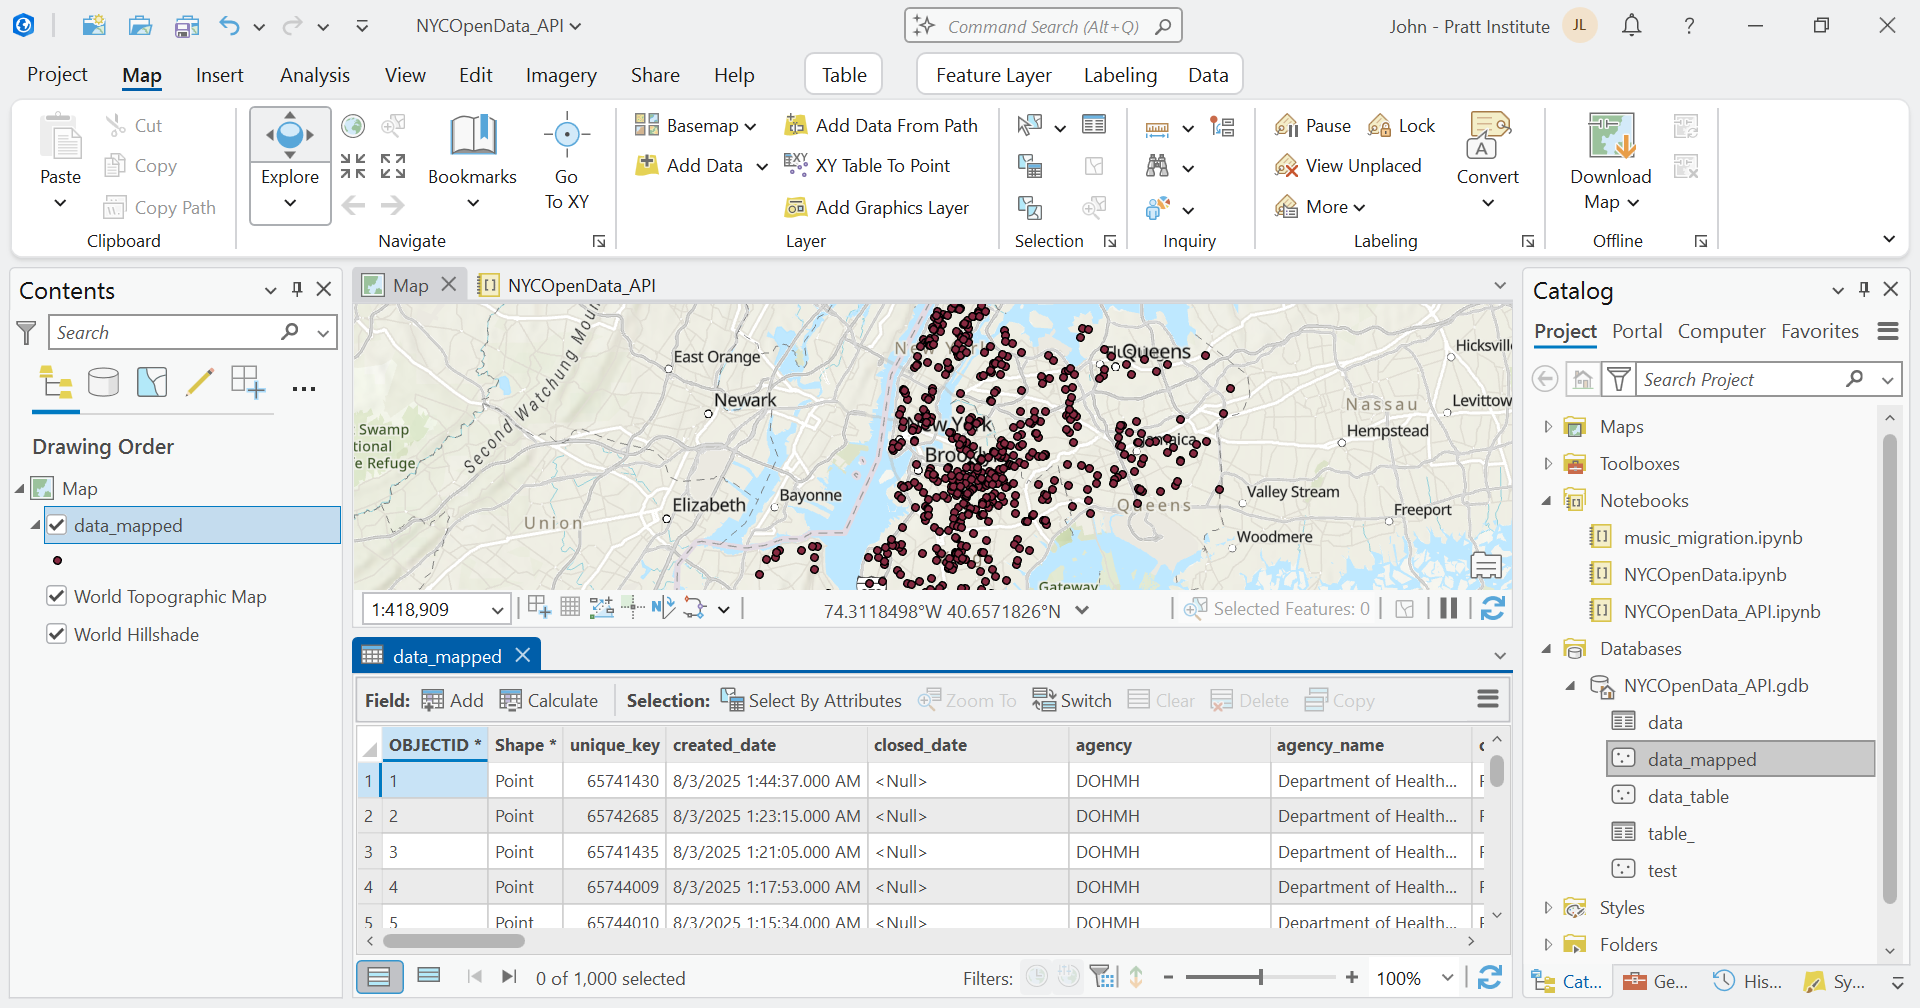


## Design an API query

Note that the NYC Open Data API limits this kind of public API call to 1000 records. But most of the time you want more records than this (e.g. the query above has over 20,000 complaints). To get around this problem, we'll use more advanced functions of the API to access the data. 

First off, you need to create an account with Tyler Technologies (the company that owns Socrata) and get a free API token. Here's [their guide](https://support.socrata.com/hc/en-us/articles/210138558-Generating-App-Tokens-and-API-Keys) on how to create app tokens and API keys. 

Create an account at evergreen.data.socrata.com and then log in. Click your name near the top right corner and look for Developer Settings. Note I had trouble seeing this on some browsers, until I clicked on my name twice. 

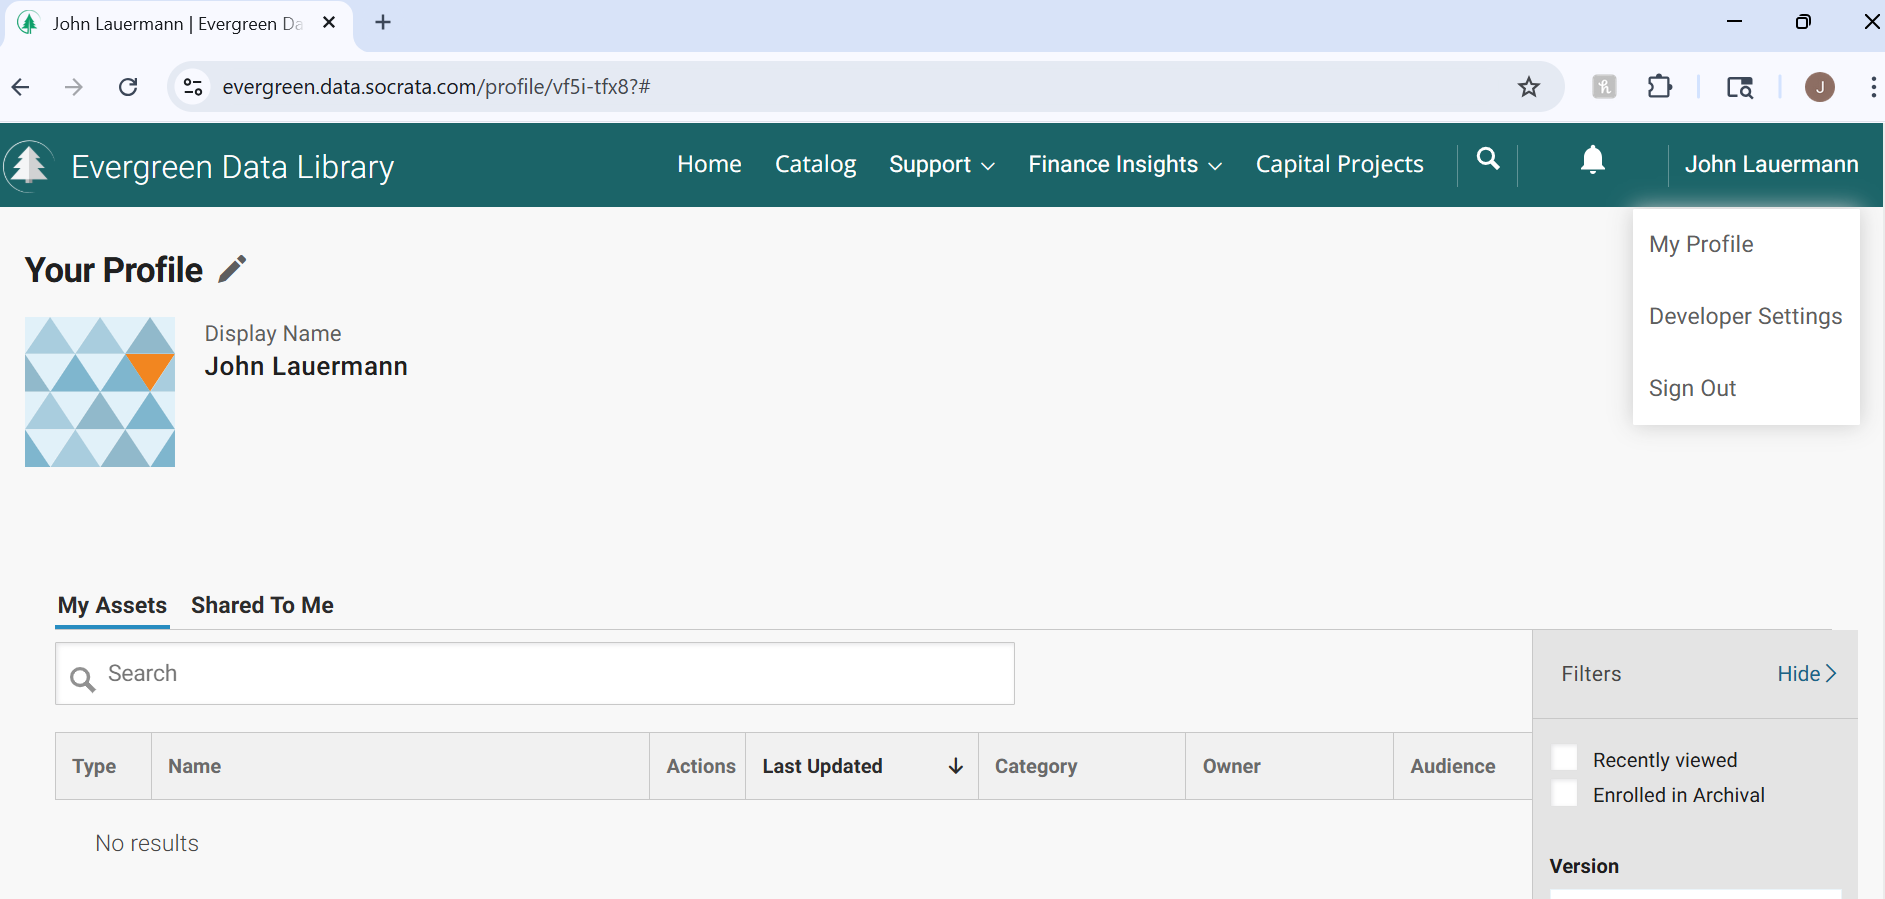

Create a new app token and then copy it for use in the script below. **Note:** Don't share your token or make it publicaly visible. 

In [9]:
#set up for Socrata API
data_url = 'data.cityofnewyork.us'  # NYC Open Data is the platform we'll query
app_token = 'your token here' # Add your token here
client = Socrata(data_url, app_token, timeout=1000)  # configuring the Socrata client
print(client)

Querying the API requires an understanding of how the query is built into the URL. For our purposes, the query has two elements: a `complaint_type` about rodents and a time range for the `created_data`. We'll use a WHERE query to build that URL. 

We first define the data set `erm2-nwe9`.

Then we create a query for time `created_date between '2025-01-01T00:00:00' and '2025-12-31T23:59:59'`, using `AND` to continue the query to include a complaint type `complaint_type like '%Rodent%'`. Note that I'm using a wildcard operator (%) to search for related terms.

Finally we'll specify a limit because the API call requires it. It can be as high as you want (in my case, there's only about 21,000 rows so a limit of 50000 is just fine). But please be a reasonable professional and avoid pulling massive amounts of data that you don't actually need. 

For building your own queries, note that NYC Open Data has an API guide for each dataset. The guide for 311 complaints is [located here](https://dev.socrata.com/foundry/data.cityofnewyork.us/erm2-nwe9). 

In [11]:
# first define the data set 
dataset_identifier = "erm2-nwe9" 

# then the query
query = "created_date between '2025-01-01T00:00:00' and '2025-12-31T23:59:59' AND complaint_type like '%Rodent%'"

# and the limit
limit = 50000

print("Dataset: " + dataset_identifier)
print("Query: " + query)

Dataset: erm2-nwe9
Query: created_date between '2025-01-01T00:00:00' and '2025-12-31T23:59:59' AND complaint_type like '%Rodent%'


In [12]:
# now submit the query
results = client.get(dataset_identifier, 
                     where=query, 
                     limit=limit)
print("Query successfully submitted.")

Query successfully submitted.


In [ ]:
# Alternative, you can write the query directly into the API call like this: 
results = client.get("erm2-nwe9", 
                     where="created_date between '2025-01-01T00:00:00' and '2025-12-31T23:59:59' AND complaint_type like '%Rodent%'",
                     order="created_date DESC",
                     limit=50000)
print("Query successfully submitted.")

In [13]:
# read data into data frame
data = pandas.DataFrame.from_records(results)
data

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location
0,63580473,2025-01-01T00:43:43.000,2025-01-02T10:24:48.000,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11237,97 MORGAN AVENUE,...,3030750025,BROOKLYN,1003065,196930,ONLINE,Unspecified,BROOKLYN,40.707184113322114,-73.93213728572762,"{'latitude': '40.707184113322114', 'longitude'..."
1,63575361,2025-01-01T01:26:59.000,2025-01-01T01:26:59.000,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Parking Lot/Garage,10457,3952 3 AVENUE,...,2029297501,BRONX,1012062,245518,MOBILE,Unspecified,BRONX,40.84052162283666,-73.89948546889276,"{'latitude': '40.84052162283666', 'longitude':..."
2,63577242,2025-01-01T01:42:12.000,2025-01-02T12:49:24.000,DOHMH,Department of Health and Mental Hygiene,Rodent,Signs of Rodents,3+ Family Apt. Building,11216,489 EASTERN PARKWAY,...,3012610048,BROOKLYN,997515,183365,MOBILE,Unspecified,BROOKLYN,40.66996137140611,-73.95218195713814,"{'latitude': '40.66996137140611', 'longitude':..."
3,63593175,2025-01-01T01:56:34.000,2025-01-02T07:54:32.000,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10468,18 EAST 198 STREET,...,2033180119,BRONX,1013908,256700,ONLINE,Unspecified,BRONX,40.871206842739696,-73.89276442848653,"{'latitude': '40.871206842739696', 'longitude'..."
4,63585687,2025-01-01T03:16:45.000,2025-01-03T15:48:49.000,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11106,32-66 35 STREET,...,4006220071,QUEENS,1005703,216189,ONLINE,Unspecified,QUEENS,40.76003930584474,-73.92256103501447,"{'latitude': '40.76003930584474', 'longitude':..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20928,65744010,2025-08-03T01:15:34.000,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10452,957 WOODYCREST AVENUE,...,2025110068,BRONX,1003936,242233,PHONE,Unspecified,BRONX,40.8315271048226,-73.92886303221528,"{'latitude': '40.8315271048226', 'longitude': ..."
20929,65744009,2025-08-03T01:17:53.000,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10452,963 WOODYCREST AVENUE,...,2025110068,BRONX,1003966,242285,PHONE,Unspecified,BRONX,40.831669762919574,-73.9287544719845,"{'latitude': '40.831669762919574', 'longitude'..."
20930,65741435,2025-08-03T01:21:05.000,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Vacant Lot,10452,951 WOODYCREST AVENUE,...,2025110074,BRONX,1003906,242182,PHONE,Unspecified,BRONX,40.831387191331984,-73.92897158905042,"{'latitude': '40.831387191331984', 'longitude'..."
20931,65742685,2025-08-03T01:23:15.000,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,3+ Family Apt. Building,11385,1754 DEKALB AVENUE,...,4034250004,QUEENS,1007437,196904,MOBILE,Unspecified,QUEENS,40.70710237273882,-73.91636827488799,"{'latitude': '40.70710237273882', 'longitude':..."


In [14]:
# save as a CSV
data.to_csv(os.path.join(default_folder,"data.csv"), index=False)
print(f"Saved to {default_folder}")

Saved to C:\Users\johnl\My Drive (jlauerma@pratt.edu)\Teaching\INFO 612 Advanced GIS\Tutorials\NYCOpenData_API


In [15]:
# Load the CSV to your geodatabase 
csv = os.path.join(default_folder, "data.csv")
arcpy.conversion.TableToGeodatabase(csv, default_gdb)
print(f"loaded data to {default_gdb}")

loaded data to C:\Users\johnl\My Drive (jlauerma@pratt.edu)\Teaching\INFO 612 Advanced GIS\Tutorials\NYCOpenData_API\NYCOpenData_API.gdb


In [16]:
# Then create point features using the lat/long information in the data
arcpy.management.XYTableToPoint(
    in_table=os.path.join(default_gdb, "data"),
    out_feature_class=os.path.join(default_gdb, "data_mapped"),
    x_field="longitude",
    y_field="latitude",
    coordinate_system="4326"  # note this is WGS 1984, a common default for NYC Open Data
)

<Result 'C:\\Users\\johnl\\My Drive (jlauerma@pratt.edu)\\Teaching\\INFO 612 Advanced GIS\\Tutorials\\NYCOpenData_API\\NYCOpenData_API.gdb\\data_mapped'>

## Futher reading
- Bauer, Mark, "Socrata Open Data API Tutorial with Python and NYC Open Data", https://github.com/mebauer/sodapy-tutorial-nyc-opendata
- Socrata "SODA Developers Guide", https://dev.socrata.com/
- Tyler Technologies, "Generating app tokens and API keys", https://support.socrata.com/hc/en-us/articles/210138558-Generating-App-Tokens-and-API-Keys